In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Discovery: Fetching S&P 500 (SPY) data for long-term regime analysis
ticker = "SPY"
data = yf.download(ticker, start="2000-01-01", end="2025-01-01")

# Discovery: Selecting only the closing price and ensuring the column name is standard
df = data[['Close']].copy()
df.columns = ['Close'] 

# Drop any potential missing values right at the start to prevent model errors
df.dropna(inplace=True)

print(f"Data for {ticker} successfully loaded.")
print(df.head())

/var/folders/2w/y8r5wlq93_19v2h8_4fzf4tm0000gn/T/ipykernel_87916/2284107696.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2000-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Data for SPY successfully loaded.
                Close
Date                 
2000-01-03  91.617073
2000-01-04  88.034279
2000-01-05  88.191788
2000-01-06  86.774399
2000-01-07  91.813858


In [2]:
# 1. Calculate Log Returns
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# 2. Calculate Rolling Volatility (21-day window)
df['Volatility'] = df['Returns'].rolling(window=21).std()

# 3. Necessary Cleaning: 
df.dropna(inplace=True)

print("Features calculated and math-gaps removed.")
print(f"Remaining data points: {len(df)}")

Features calculated and math-gaps removed.
Remaining data points: 6268


In [3]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

# 1. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Returns', 'Volatility']])

# 2. Initialize the Hidden Markov Model
model = GaussianHMM(
    n_components=3, 
    covariance_type="full", 
    n_iter=1000,
    random_state=42
)

print("Training Initial HMM...")
model.fit(X_scaled)

# 3. Predict Hidden States
df['Regime'] = model.predict(X_scaled)

print("Training Complete. Identified Regimes for the last 10 days:")
print(df[['Close', 'Regime']].tail(10))

Training Initial HMM...
Training Complete. Identified Regimes for the last 10 days:
                 Close  Regime
Date                          
2024-12-17  595.272583       1
2024-12-18  577.531372       0
2024-12-19  577.353943       0
2024-12-20  584.288635       0
2024-12-23  587.787476       0
2024-12-24  594.320740       0
2024-12-26  594.360413       0
2024-12-27  588.103821       0
2024-12-30  581.392578       0
2024-12-31  579.277405       0


In [4]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

# 1. Feature Scaling (Discovery: Essential for HMM convergence)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Returns', 'Volatility']])

# 2. Initialize the Baseline Hidden Markov Model
model = GaussianHMM(
    n_components=3, 
    covariance_type="full", 
    n_iter=1000,           
    random_state=42
)

print("Training Initial Baseline HMM...")
model.fit(X_scaled)

# 3. Predict Hidden States (Regimes)
df['Regime'] = model.predict(X_scaled)

print("Baseline Complete. Previewing identified regimes:")
print(df[['Close', 'Regime']].tail(10))

Training Initial Baseline HMM...
Baseline Complete. Previewing identified regimes:
                 Close  Regime
Date                          
2024-12-17  595.272583       1
2024-12-18  577.531372       0
2024-12-19  577.353943       0
2024-12-20  584.288635       0
2024-12-23  587.787476       0
2024-12-24  594.320740       0
2024-12-26  594.360413       0
2024-12-27  588.103821       0
2024-12-30  581.392578       0
2024-12-31  579.277405       0


In [ ]:


# 1. Mapping the regimes
df['Signal'] = np.where(df['Regime'] == 1, 1, 0)

# 2. Prevent Look-Ahead Bias
df['Signal'] = df['Signal'].shift(1)

# 3. Calculate Strategy Performance
df['Strategy_Returns'] = df['Returns'] * df['Signal']

# 4. Convert Log Returns to Cumulative Wealth
df['Buy_Hold_Cum'] = np.exp(df['Returns'].cumsum())
df['Strategy_Cum'] = np.exp(df['Strategy_Returns'].cumsum())

# 5. Professional Discovery: Sharpe Ratio
strat_std = df['Strategy_Returns'].std()
if strat_std > 0:
    sharpe = (df['Strategy_Returns'].mean() / strat_std) * np.sqrt(252)
    print(f"Baseline Strategy Sharpe Ratio: {sharpe:.2f}")

print("Backtest Complete. Ready for Visualization.")

Baseline Strategy Sharpe Ratio: 0.58
Backtest Complete. Ready for Visualization.


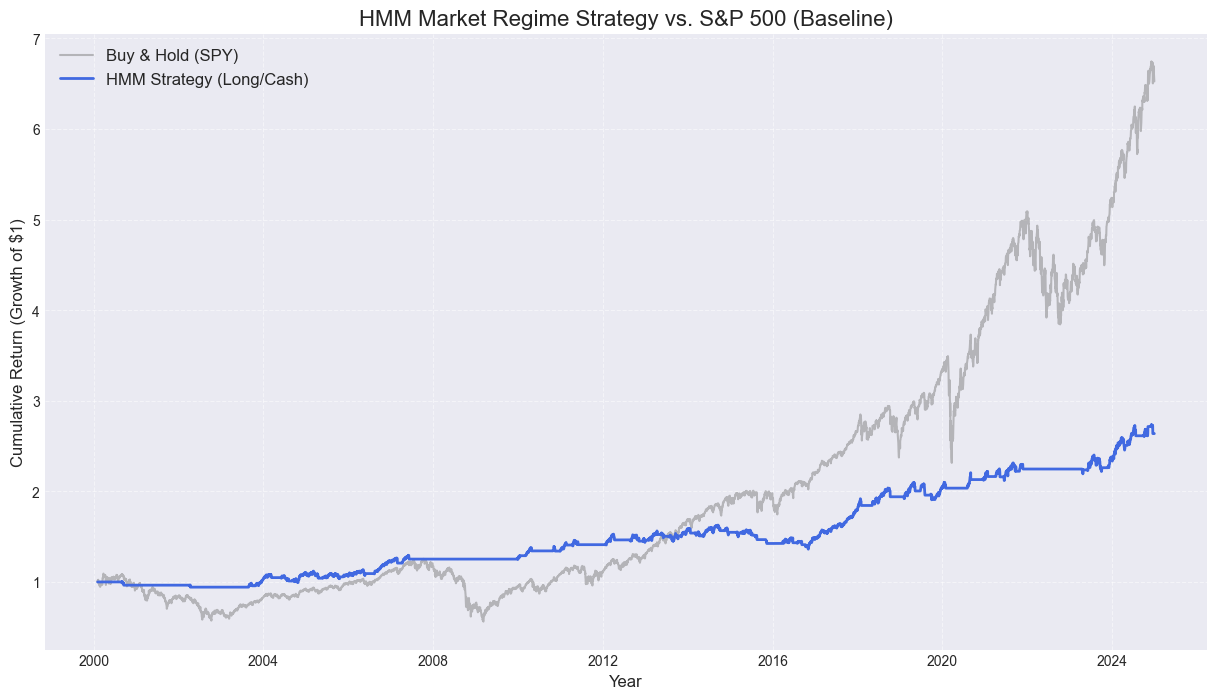

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid') 
plt.figure(figsize=(15, 8))

# 1. Plot Buy & Hold (The Benchmark)
plt.plot(df.index, df['Buy_Hold_Cum'], label='Buy & Hold (SPY)', color='gray', alpha=0.5)

# 2. Plot HMM Strategy
plt.plot(df.index, df['Strategy_Cum'], label='HMM Strategy (Long/Cash)', color='royalblue', linewidth=2)

# 3. Annotating the "Discovery"
plt.title('HMM Market Regime Strategy vs. S&P 500 (Baseline)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Return (Growth of $1)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.show()

In [7]:
# 1. Calculate Total Return
total_return_bh = df['Buy_Hold_Cum'].iloc[-1] - 1
total_return_strat = df['Strategy_Cum'].iloc[-1] - 1

# 2. Calculate Annualized Volatility
vol_bh = df['Returns'].std() * np.sqrt(252)
vol_strat = df['Strategy_Returns'].std() * np.sqrt(252)

# 3. Calculate Sharpe Ratio
sharpe_bh = (df['Returns'].mean() * 252) / vol_bh
sharpe_strat = (df['Strategy_Returns'].mean() * 252) / vol_strat

# 4. Professional Addition: Maximum Drawdown (Discovery)
def calculate_drawdown(cum_returns):
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    return drawdown.min()

mdd_bh = calculate_drawdown(df['Buy_Hold_Cum'])
mdd_strat = calculate_drawdown(df['Strategy_Cum'])

print(f"--- Performance Metrics ---")
print(f"Total Return (Buy & Hold): {total_return_bh:.2%}")
print(f"Total Return (HMM Strategy): {total_return_strat:.2%}")
print("-" * 30)
print(f"Annual Volatility (Buy & Hold): {vol_bh:.2%}")
print(f"Annual Volatility (HMM Strategy): {vol_strat:.2%}")
print("-" * 30)
print(f"Sharpe Ratio (Buy & Hold): {sharpe_bh:.2f}")
print(f"Sharpe Ratio (HMM Strategy): {sharpe_strat:.2f}")
print("-" * 30)
print(f"Max Drawdown (Buy & Hold): {mdd_bh:.2%}")
print(f"Max Drawdown (HMM Strategy): {mdd_strat:.2%}")

--- Performance Metrics ---
Total Return (Buy & Hold): 552.47%
Total Return (HMM Strategy): 163.74%
------------------------------
Annual Volatility (Buy & Hold): 19.34%
Annual Volatility (HMM Strategy): 6.72%
------------------------------
Sharpe Ratio (Buy & Hold): 0.39
Sharpe Ratio (HMM Strategy): 0.58
------------------------------
Max Drawdown (Buy & Hold): -55.19%
Max Drawdown (HMM Strategy): -16.36%


Generating Institutional Tear Sheet...


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.741%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2000-02-03
End date,2024-12-31
Total months,298
,Backtest
Annual return,3.741%
Cumulative returns,149.299%
Annual volatility,6.716%
Sharpe ratio,0.58
Calmar ratio,0.22
Stability,0.95
Max drawdown,-16.883%


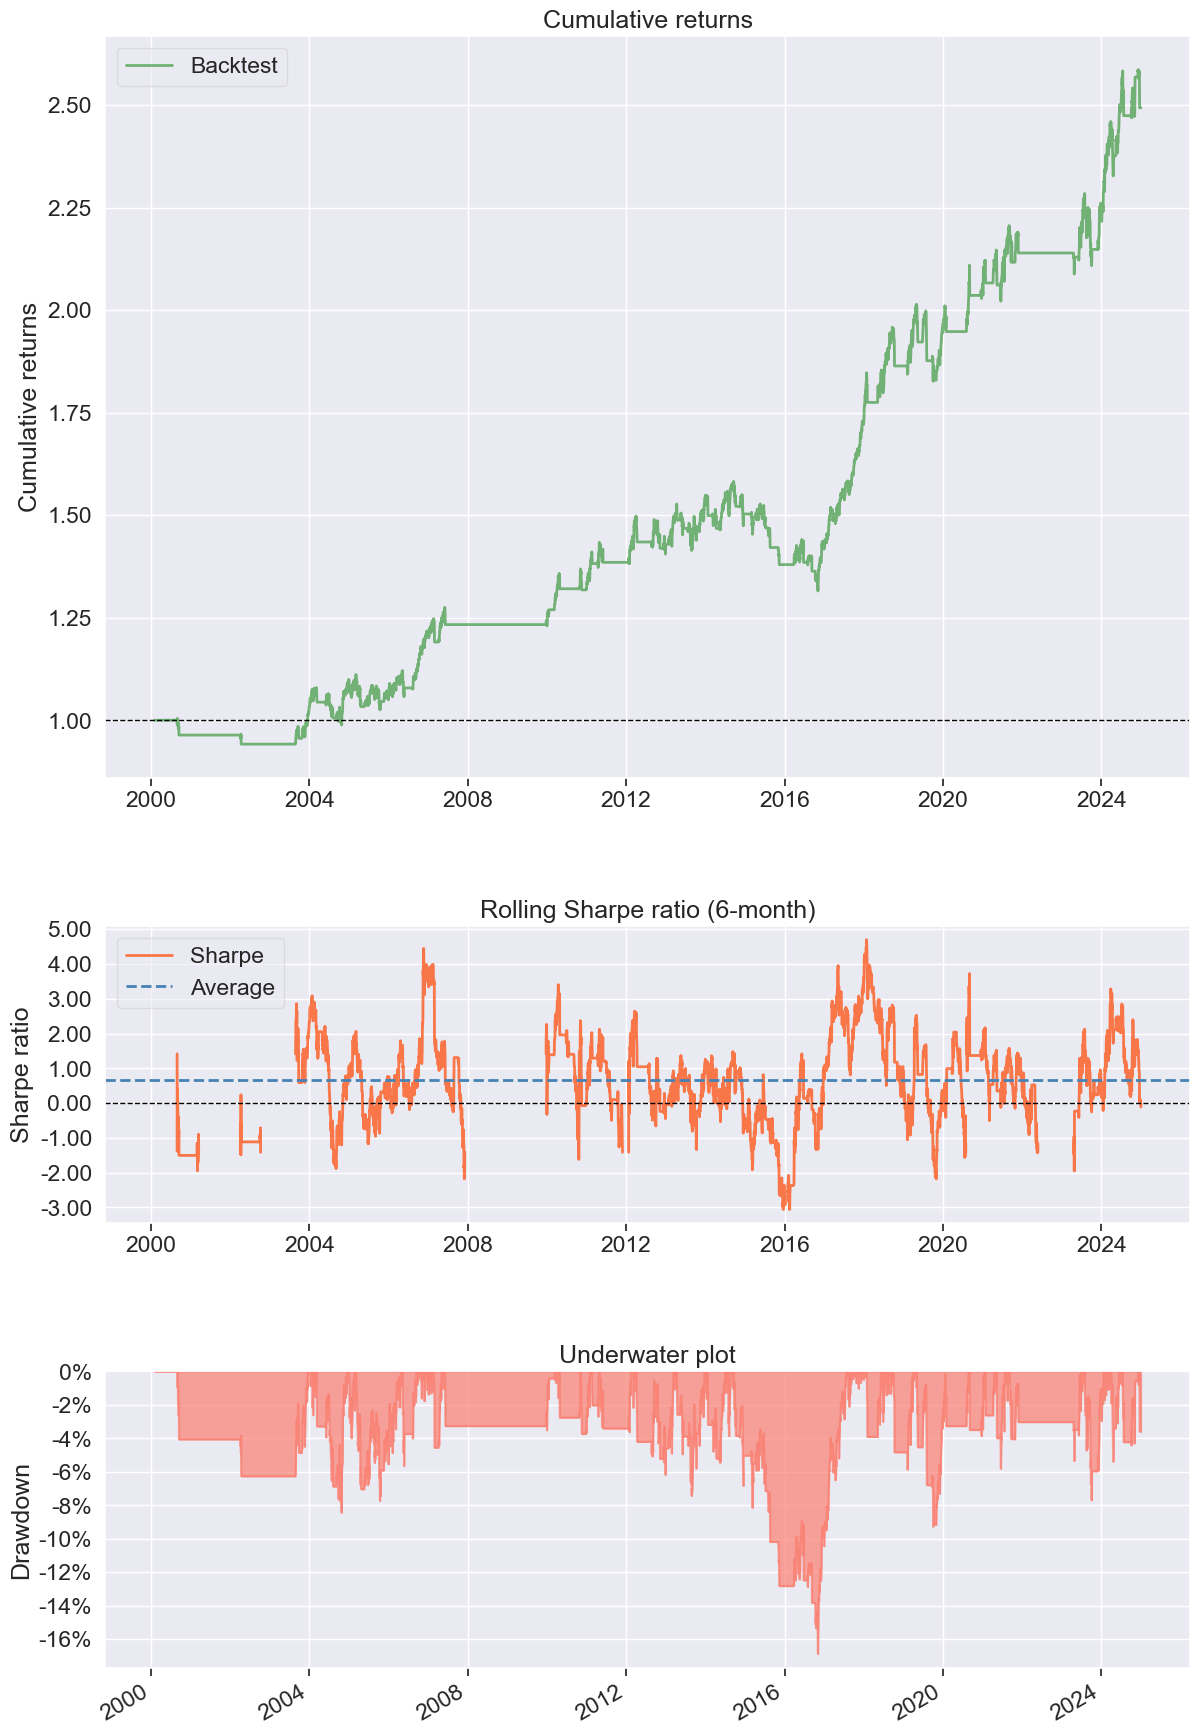

In [ ]:
import pyfolio as pf
import warnings

strategy_returns = df['Strategy_Returns'].copy().dropna()
try:
    print("Generating Institutional Tear Sheet...")
    pf.create_simple_tear_sheet(strategy_returns)
except Exception as e:
    print(f"Note: Pyfolio requires specific indexing. Manual check suggested: {e}")


In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from hmmlearn.hmm import GaussianHMM

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 1. Define Walk-Forward Parameters
start_train_size = 1250
rebalance_period = 10
total_days = len(df)

# 2. Initialize Storage Lists
signals = []
dates = []

print(f"--- Walk-Forward Configuration ---")
print(f"Training Window: {start_train_size} days")
print(f"Rebalance Frequency: Every {rebalance_period} trading days")
print(f"Total Testable Days: {total_days - start_train_size}")

--- Walk-Forward Configuration ---
Training Window: 1250 days
Rebalance Frequency: Every 10 trading days
Total Testable Days: 5018


In [10]:
import warnings
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) 
    
    print("Starting Walk-Forward Loop...")
    for t in range(start_train_size, total_days, rebalance_period):
        
        # 1. Rolling Window Setup:
        train_data = df.iloc[:t][['Returns', 'Volatility']]
        
        # 2. Discovery: In-Loop Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(train_data)
        
        # 3. Model Configuration
        model = GaussianHMM(n_components=3, 
                            covariance_type="full", 
                            n_iter=1000, 
                            tol=0.01, 
                            min_covar=0.001, 
                            random_state=42)
        
        # 4. Fit Model & Handle Convergence
        try:
            model.fit(X_train_scaled)
        except Exception:
            gap = min(rebalance_period, total_days - t)
            signals.extend([0] * gap)
            dates.extend(df.index[t:t+gap])
            continue
        
        # 5. Dynamic State Identification (The "Bull" State)
        best_sharpe = -np.inf
        bull_state_id = 0
        
        for i in range(model.n_components):
            mean_return = model.means_[i][0]
            mean_vol = model.means_[i][1]
            sharpe = mean_return / (mean_vol + 1e-6)
            
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                bull_state_id = i
                
        # 6. Predict for the Next Out-of-Sample Period
        end_idx = min(t + rebalance_period, total_days)
        next_chunk = df.iloc[t:end_idx][['Returns', 'Volatility']]
        
        # Discovery: We use the same scaler from the training set to transform the test set.
        X_test_scaled = scaler.transform(next_chunk)
        
        try:
            pred_states = model.predict(X_test_scaled)
            chunk_signals = [1 if state == bull_state_id else 0 for state in pred_states]
        except:
            chunk_signals = [0] * len(next_chunk)

        # 7. Store Results
        signals.extend(chunk_signals)
        dates.extend(df.index[t:end_idx])

print("Loop Complete. Ready for Out-of-Sample Analysis.")

Starting Walk-Forward Loop...
Loop Complete. Ready for Out-of-Sample Analysis.


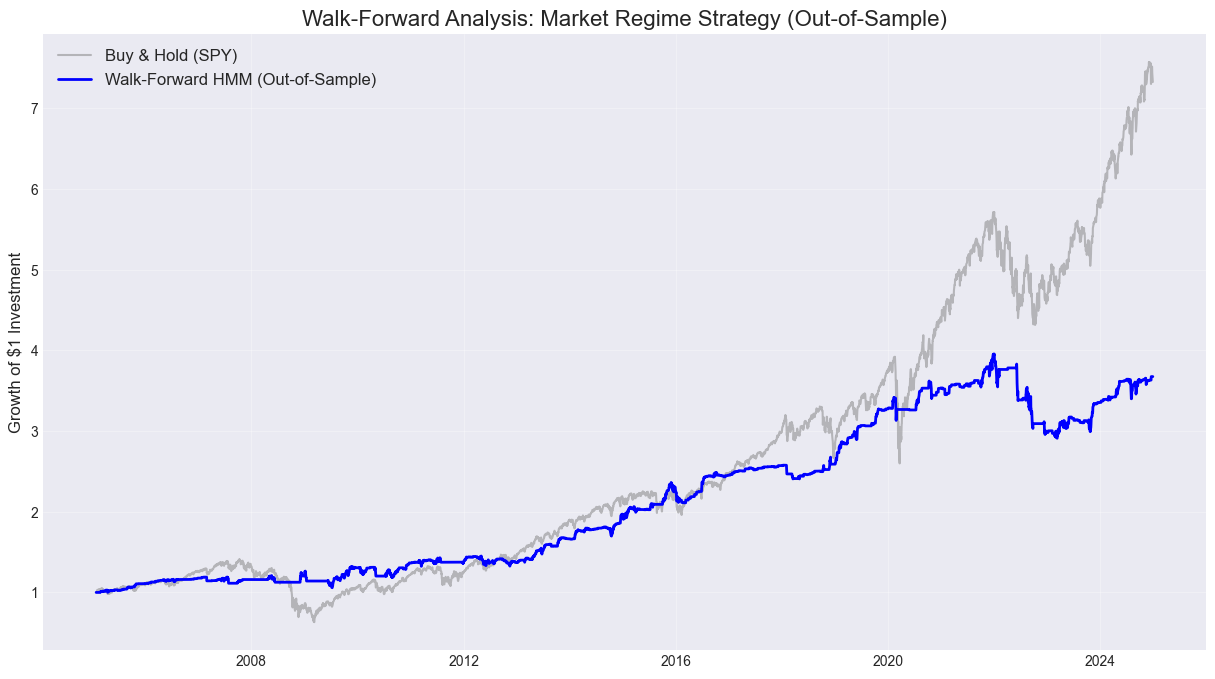

Metric                    | Buy & Hold      | Walk-Forward HMM
-----------------------------------------------------------------
Sharpe Ratio              | 0.52            | 0.76           
Annual Volatility         | 19.07%          | 8.60%          
Total Return              | 632.69%         | 267.54%        


In [11]:
import matplotlib.pyplot as plt

# 1. Integrate Walk-Forward Results
df_wf = pd.DataFrame({'Date': dates, 'WF_Signal': signals})
df_wf.set_index('Date', inplace=True)
df_final = df.join(df_wf, how='inner')

# 2. Prevent Look-Ahead Bias
df_final['WF_Signal'] = df_final['WF_Signal'].shift(1)

# 3. Calculate Realistic Returns
df_final['WF_Strategy_Returns'] = df_final['Returns'] * df_final['WF_Signal']

# 4. Calculate Cumulative Growth
df_final['Buy_Hold_Cum'] = np.exp(df_final['Returns'].cumsum())
df_final['WF_Strategy_Cum'] = np.exp(df_final['WF_Strategy_Returns'].cumsum())

# 5. Plot Professional Equity Curve
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(15, 8))
plt.plot(df_final.index, df_final['Buy_Hold_Cum'], label='Buy & Hold (SPY)', color='gray', alpha=0.5)
plt.plot(df_final.index, df_final['WF_Strategy_Cum'], label='Walk-Forward HMM (Out-of-Sample)', color='blue', linewidth=2)

plt.title('Walk-Forward Analysis: Market Regime Strategy (Out-of-Sample)', fontsize=16)
plt.ylabel('Growth of $1 Investment', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# 6. Final Performance Benchmarking
total_ret_bh = df_final['Buy_Hold_Cum'].iloc[-1] - 1
total_ret_strat = df_final['WF_Strategy_Cum'].iloc[-1] - 1

vol_bh = df_final['Returns'].std() * np.sqrt(252)
vol_strat = df_final['WF_Strategy_Returns'].std() * np.sqrt(252)

sharpe_bh = (df_final['Returns'].mean() * 252) / vol_bh
sharpe_strat = (df_final['WF_Strategy_Returns'].mean() * 252) / vol_strat

print(f"{'Metric':<25} | {'Buy & Hold':<15} | {'Walk-Forward HMM':<15}")
print("-" * 65)
print(f"{'Sharpe Ratio':<25} | {sharpe_bh:<15.2f} | {sharpe_strat:<15.2f}")
print(f"{'Annual Volatility':<25} | {vol_bh:<15.2%} | {vol_strat:<15.2%}")
print(f"{'Total Return':<25} | {total_ret_bh:<15.2%} | {total_ret_strat:<15.2%}")